<a href="https://colab.research.google.com/github/Jungro-Lee/Jungro-Lee/blob/master/PS_predictions_Organ_Only.(2)ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.nn import functional as F
import time
from PIL import Image
import PIL
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torchsummary import summary as model_summary
import glob
import nibabel as nib
import skimage
import sklearn
from sklearn import model_selection
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
import tempfile
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
    Resized,
    NormalizeIntensityd,
    ToTensord,
    AsDiscrete,
)
from monai.config import print_config
from typing import Optional

from tqdm import tqdm
# from tqdm.notebook import tqdm

print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
print(f'torch.cuda.get_device_name(0): {torch.cuda.get_device_name(0)}')
print(f'torch.version.cuda: {torch.version.cuda}')
print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
print()
monai.config.print_config()

torch.cuda.is_available(): True
torch.cuda.get_device_name(0): Tesla T4
torch.version.cuda: 11.6
torch.cuda.device_count(): 1

MONAI version: 1.1.0
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.0
gdown version: 4.6.6
TorchVision version: 0.14.1+cu116
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.4.4
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

## 구성
1. 데이터 불러오기
2. 데이터 체크(형태, 구조, 자료형 확인)
3. 데이터 전처리
    - minmax
    - resize 등
4. 2번 다시
5. 시각화

In [22]:
### HYPER PARAMETER ###

RANDOM_SEED = 831
IMAGE_SIZE = (128, 128, 128)
BATCH_SIZE = 2
NUM_CLASS = 2
EPOCHS = 200
test_ratio, val_ratio = 0.1, 0.2

MODEL_SAVE = True
if MODEL_SAVE:
    model_dir1 = r"C:\Users\jungr\OneDrive\바탕 화면\data"
    model_dir2 = 'Segmentation(3D)-UNETR(bg)'
    MODEL_SAVE_PATH = os.path.join(model_dir1, model_dir2)
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
print(DEVICE)
MODEL_SAVE_PATH

cuda


'C:\\Users\\jungr\\OneDrive\\바탕 화면\\data/Segmentation(3D)-UNETR(bg)'

0. 데이터 준비
- 데이터가 있으면 `data_dir`를 자신의 경로에 맞게 수정해주세요.
- 데이터가 없으면 `USE_MY_DATA` 를 `False`로 두고 다운로드 받으면 됩니다.
- The dataset comes from http://medicaldecathlon.com/.

In [23]:
USE_MY_DATA = False

if not USE_MY_DATA:
    directory = os.environ.get("MONAI_DATA_DIRECTORY")
    root_dir = tempfile.mkdtemp() if directory is None else directory
    print(f"root dir is: {root_dir}")
    
    resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
    md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

    compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
    data_dir = os.path.join(root_dir, "Task09_Spleen")
    if not os.path.exists(data_dir):
        download_and_extract(resource, compressed_file, root_dir, md5)

else:
    data_dir = r"C:\Users\jungr\OneDrive\바탕 화면\data\spleen_10.nii.gz"

root dir is: /tmp/tmprcy1s3g3


Task09_Spleen.tar: 1.50GB [00:58, 27.5MB/s]                            

2023-04-02 06:38:48,961 - INFO - Downloaded: /tmp/tmprcy1s3g3/Task09_Spleen.tar


2023-04-02 06:38:51,903 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-04-02 06:38:51,907 - INFO - Writing into directory: /tmp/tmprcy1s3g3.


In [24]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
train_data_dicts[0]

{'image': '/tmp/tmprcy1s3g3/Task09_Spleen/imagesTr/spleen_10.nii.gz',
 'label': '/tmp/tmprcy1s3g3/Task09_Spleen/labelsTr/spleen_10.nii.gz'}

In [25]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

TrainSet, TestSet = model_selection.train_test_split(data_dicts, test_size=test_ratio, random_state=RANDOM_SEED)
TrainSet, ValSet = model_selection.train_test_split(TrainSet, test_size=val_ratio, random_state=RANDOM_SEED)
print('TrainSet:', len(TrainSet), 'ValSet:', len(ValSet), 'TestSet:', len(TestSet))

TrainSet: 28 ValSet: 8 TestSet: 5


In [26]:
for i in range(3):
    sample_img = nib.load(TrainSet[i]['image']).get_fdata()
    sample_mask = nib.load(TrainSet[i]['label']).get_fdata()
    print(f"[sample {i+1}] {os.path.basename(TrainSet[i]['image'])} {os.path.basename(TrainSet[i]['label'])}")
    print(sample_img.shape, sample_img.dtype, np.min(sample_img), np.max(sample_img))
    print(sample_mask.shape, sample_mask.dtype, np.unique(sample_mask))

[sample 1] spleen_2.nii.gz spleen_2.nii.gz
(512, 512, 90) float64 -1024.0 3071.0
(512, 512, 90) float64 [0. 1.]
[sample 2] spleen_19.nii.gz spleen_19.nii.gz
(512, 512, 51) float64 -1024.0 1372.0
(512, 512, 51) float64 [0. 1.]
[sample 3] spleen_17.nii.gz spleen_17.nii.gz
(512, 512, 95) float64 -1024.0 1964.0
(512, 512, 95) float64 [0. 1.]


In [27]:
from monai.transforms.compose import Transform, MapTransform

class MinMax(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] -= np.min(d[key])
            d[key] /= np.max(d[key])
        return d

loader = LoadImaged(keys=("image",'label'), image_only=False)
ensure_channel_first = EnsureChannelFirstd(keys=["image",'label'])
orientation = Orientationd(keys=["image",'label'], axcodes="RAS")
resize_img = Resized(keys=["image",], spatial_size=(IMAGE_SIZE), mode='trilinear')
resize_mask = Resized(keys=['label',], spatial_size=(IMAGE_SIZE), mode='nearest-exact')
# normalize = NormalizeIntensityd(keys=["image",])
minmax = MinMax(keys=['image',])

In [28]:
transforms = Compose([
    LoadImaged(keys=("image",'label'), image_only=False),
    EnsureChannelFirstd(keys=["image",'label']),
    Orientationd(keys=["image",'label'], axcodes="RAS"),
    Resized(keys=["image",], spatial_size=(IMAGE_SIZE), mode='trilinear'),
    Resized(keys=['label',], spatial_size=(IMAGE_SIZE), mode='nearest-exact'),
    # normalize = NormalizeIntensityd(keys=["image",])
    MinMax(keys=['image',]),
    ToTensord(keys=["image", "label"]),
    ])

SampleSet = transforms(TestSet[:3])

for i in range(3):
    sample_img = SampleSet[i]['image']
    sample_mask = SampleSet[i]['label']
    print(f"[sample {i+1}]")
    print(sample_img.shape, sample_img.dtype, torch.min(sample_img), torch.max(sample_img))
    print(sample_mask.shape, sample_mask.dtype, torch.unique(sample_mask))

[sample 1]
torch.Size([1, 128, 128, 128]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 128, 128, 128]) torch.float32 tensor([0., 1.])
[sample 2]
torch.Size([1, 128, 128, 128]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 128, 128, 128]) torch.float32 tensor([0., 1.])
[sample 3]
torch.Size([1, 128, 128, 128]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 128, 128, 128]) torch.float32 tensor([0., 1.])


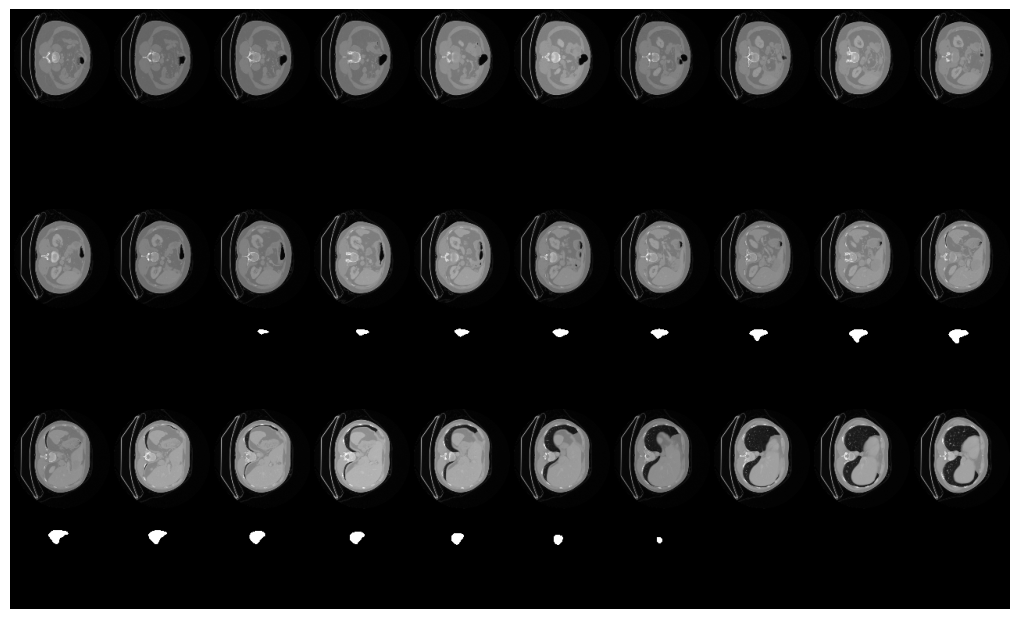

In [29]:
ncols, nrows = 10, 6
interval = int(IMAGE_SIZE[-1]//(ncols*nrows/2))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols,nrows))
cnt1, cnt2 = 0, 0
for i in range(nrows):
    for j in range(ncols):
        if i%2 == 0:
            axes[i,j].imshow(SampleSet[0]['image'][0,:,:,cnt1], cmap='gray')
            cnt1+=interval
        else:
            axes[i,j].imshow(SampleSet[0]['label'][0,:,:,cnt2], cmap='gray')
            cnt2+=interval
        axes[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()  

In [30]:
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

train_ds = CacheDataset(
    data=TrainSet,
    transform=transforms,
    cache_num=4,
    cache_rate=1.0,
    num_workers=0)
val_ds = CacheDataset(
    data=ValSet, transform=transforms, cache_num=2, cache_rate=1.0, num_workers=0)
test_ds = CacheDataset(
    data=TestSet, transform=transforms, cache_num=2, cache_rate=1.0, num_workers=0)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


In [31]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torch import Tensor

class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)
    
    
class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)    

class Embeddings(nn.Module):
    def __init__(self, input_shape, patch_size=16, embed_dim=768, dropout=0.):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = input_shape[-4]
        self.n_patches = int((input_shape[-1] * input_shape[-2] * input_shape[-3]) / (patch_size * patch_size * patch_size))
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=self.in_channels, out_channels=self.embed_dim,
                                          kernel_size=self.patch_size, stride=self.patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, self.embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = rearrange(x, "b n h w d -> b (h w d) n")
        # batch, embed_dim, height/patch, width/patch, depth/patch
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, depth=12, dropout=0., extract_layers=[3,6,9,12]):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(embed_dim, MultiHeadAttention(embed_dim, num_heads, dropout)),
                PreNorm(embed_dim, FeedForwardBlock(embed_dim, expansion=4))
            ]))            
        self.extract_layers = extract_layers
        
    def forward(self, x):
        extract_layers = []
        
        for cnt, (attn, ff) in enumerate(self.layers):
            x = attn(x) + x
            x = ff(x) + x
            if cnt+1 in self.extract_layers:
                extract_layers.append(x)
            
        return extract_layers

class UNETR(nn.Module):
    def __init__(self, img_shape=(224, 224, 224), input_dim=3, output_dim=3, 
                 embed_dim=768, patch_size=16, num_heads=8, dropout=0.1, light_r=4):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]
        self.conv_channels = [int(i/light_r) for i in [32, 64, 128, 256, 512, 1024]]

        self.embedding = Embeddings((input_dim,*img_shape))
        
        # Transformer Encoder
        self.transformer = \
            TransformerBlock(
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, self.conv_channels[0], 3),
                Conv3DBlock(self.conv_channels[0], self.conv_channels[1], 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, self.conv_channels[2]),
                Deconv3DBlock(self.conv_channels[2], self.conv_channels[2]),
                Deconv3DBlock(self.conv_channels[2], self.conv_channels[2])
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, self.conv_channels[3]),
                Deconv3DBlock(self.conv_channels[3], self.conv_channels[3]),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, self.conv_channels[4])

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, self.conv_channels[4])

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[5], self.conv_channels[3]),
                Conv3DBlock(self.conv_channels[3], self.conv_channels[3]),
                Conv3DBlock(self.conv_channels[3], self.conv_channels[3]),
                SingleDeconv3DBlock(self.conv_channels[3], self.conv_channels[3])
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[4], self.conv_channels[2]),
                Conv3DBlock(self.conv_channels[2], self.conv_channels[2]),
                SingleDeconv3DBlock(self.conv_channels[2], self.conv_channels[2])
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[3], self.conv_channels[1]),
                Conv3DBlock(self.conv_channels[1], self.conv_channels[1]),
                SingleDeconv3DBlock(self.conv_channels[1], self.conv_channels[1])
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[2], self.conv_channels[1]),
                Conv3DBlock(self.conv_channels[1], self.conv_channels[1]),
                SingleConv3DBlock(self.conv_channels[1], output_dim, 1)
            )

    def forward(self, x):
        z0 = x
        x = self.embedding(x)
        z = self.transformer(x)
        z3, z6, z9, z12 = z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output

In [32]:
from monai.networks.nets import UNETR

model = UNETR(
    in_channels=1,
    out_channels=NUM_CLASS,
    img_size=IMAGE_SIZE,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).float()
model = model.to(DEVICE)
# model_summary(model, (1,*IMAGE_SIZE), device=DEVICE.type)

In [33]:
from monai.losses import DiceCELoss, DiceLoss

torch.backends.cudnn.benchmark = True # ??

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

LossFuncion = monai.losses.DiceLoss(include_background=False, to_onehot_y=False, softmax=True)
MetricDice = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [34]:
def BinaryOutput(output, keepdim=True):
    shape = output.shape
    argmax_idx = torch.argmax(output, axis=1, keepdim=True)
    argmax_oh = F.one_hot(argmax_idx, num_classes=NUM_CLASS)
    if keepdim:
        argmax_oh = torch.squeeze(argmax_oh, dim=1)
    if len(shape) == 5:
        argmax_oh = argmax_oh.permute(0,4,1,2,3)
    elif len(shape) == 4:
        argmax_oh = argmax_oh.permute(0,3,1,2)
    
    return argmax_oh

In [35]:
from monai.losses.dice import DiceLoss, one_hot

def train(epoch, train_loader):
    model.train()
    mean_epoch_loss = 0
    mean_dice_score = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X EPOCHS) (loss=X.X) (dice score=%.5f)", 
        dynamic_ncols=True)
    
    for step, batch in enumerate(epoch_iterator):
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        y = torch.squeeze(y, dim=1)
        y = one_hot(y[:, None, ...], num_classes=NUM_CLASS)
        
        logit_map = model(x)
        loss = LossFuncion(logit_map, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        mean_epoch_loss += loss.item()
        
        bi_output = BinaryOutput(logit_map)
        MetricDice(bi_output, y)
        dice_score = MetricDice.aggregate().item()
        mean_dice_score += dice_score
        
        epoch_iterator.set_description(
            "Training (%d / %d EPOCHS) (loss=%2.5f) (dice score=%.5f)" 
            % (epoch, EPOCHS, loss, dice_score))
    
    mean_epoch_loss /= len(epoch_iterator)
    mean_dice_score /= len(epoch_iterator)
    
    return mean_epoch_loss, mean_dice_score



def evaluate(epoch, test_loader):
    model.eval() 
    mean_epoch_loss = 0
    mean_dice_score = 0
    epoch_iterator = tqdm(
        test_loader, desc="Evaluating (X / X EPOCHS) (loss=X.X) (dice score=%.5f)", 
        dynamic_ncols=True)
    
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator):
            x, y = (batch["image"].cuda(), batch["label"].cuda())
            y = torch.squeeze(y, dim=1)
            y = one_hot(y[:, None, ...], num_classes=NUM_CLASS)

            logit_map = model(x)
            loss = LossFuncion(logit_map, y)
            mean_epoch_loss += loss.item()

            bi_output = BinaryOutput(logit_map)
            MetricDice(bi_output, y)
            dice_score = MetricDice.aggregate().item()
            mean_dice_score += dice_score

            epoch_iterator.set_description(
                "Evaluating (%d / %d EPOCHS) (loss=%2.5f) (dice score=%.5f)" 
                % (epoch, EPOCHS, loss, dice_score))

    mean_epoch_loss /= len(epoch_iterator)
    mean_dice_score /= len(epoch_iterator)
    
    MetricDice.reset() # reset the status for next validation round
    
    return mean_epoch_loss, mean_dice_score    


In [ ]:
losses = {'train':[], 'val':[]}
dice_scores = {'train':[], 'val':[]}
best_metric, best_epoch = 999, -1

for epoch in range(1, EPOCHS+1):
    train_loss, train_dice_score = train(epoch, train_loader)
    val_loss, val_dice_score = evaluate(epoch, val_loader)
    
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    dice_scores['train'].append(train_dice_score)
    dice_scores['val'].append(val_dice_score)

    if losses['val'][-1] < best_metric:
        best_metric = losses['val'][-1]
        best_epoch = epoch
        print(f'Best record! [{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')
        if MODEL_SAVE:
            model_name = f'{best_epoch}_{best_metric}.pth'
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, model_name))
            print('saved model')


Training (1 / 200 EPOCHS) (loss=0.98851) (dice score=0.00898): 100%|██████████| 14/14 [00:57<00:00,  4.07s/it]
Evaluating (1 / 200 EPOCHS) (loss=0.98776) (dice score=0.01062): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [1] Test Loss: 0.984561, Dice score: 0.009796
saved model


Training (2 / 200 EPOCHS) (loss=0.98566) (dice score=0.01613): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (2 / 200 EPOCHS) (loss=0.98601) (dice score=0.01693): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Best record! [2] Test Loss: 0.982266, Dice score: 0.016410
saved model


Training (3 / 200 EPOCHS) (loss=0.97388) (dice score=0.01946): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (3 / 200 EPOCHS) (loss=0.98383) (dice score=0.02062): 100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Best record! [3] Test Loss: 0.979439, Dice score: 0.019889
saved model


Training (4 / 200 EPOCHS) (loss=0.96971) (dice score=0.03327): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (4 / 200 EPOCHS) (loss=0.98158) (dice score=0.03680): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [4] Test Loss: 0.976424, Dice score: 0.034908
saved model


Training (5 / 200 EPOCHS) (loss=0.97960) (dice score=0.05061): 100%|██████████| 14/14 [00:59<00:00,  4.25s/it]
Evaluating (5 / 200 EPOCHS) (loss=0.97965) (dice score=0.05708): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Best record! [5] Test Loss: 0.975205, Dice score: 0.053279
saved model


Training (6 / 200 EPOCHS) (loss=0.96438) (dice score=0.08223): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (6 / 200 EPOCHS) (loss=0.97652) (dice score=0.08885): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [6] Test Loss: 0.971353, Dice score: 0.084705
saved model


Training (7 / 200 EPOCHS) (loss=0.98185) (dice score=0.10841): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (7 / 200 EPOCHS) (loss=0.97633) (dice score=0.11335): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [7] Test Loss: 0.970368, Dice score: 0.109440
saved model


Training (8 / 200 EPOCHS) (loss=0.97978) (dice score=0.10616): 100%|██████████| 14/14 [00:58<00:00,  4.19s/it]
Evaluating (8 / 200 EPOCHS) (loss=0.97495) (dice score=0.11583): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [8] Test Loss: 0.969515, Dice score: 0.110281
saved model


Training (9 / 200 EPOCHS) (loss=0.98402) (dice score=0.13154): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (9 / 200 EPOCHS) (loss=0.97526) (dice score=0.14304): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [9] Test Loss: 0.967918, Dice score: 0.136478
saved model


Training (10 / 200 EPOCHS) (loss=0.98441) (dice score=0.15338): 100%|██████████| 14/14 [00:58<00:00,  4.19s/it]
Evaluating (10 / 200 EPOCHS) (loss=0.97388) (dice score=0.16210): 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Best record! [10] Test Loss: 0.967765, Dice score: 0.156423
saved model


Training (11 / 200 EPOCHS) (loss=0.95583) (dice score=0.16058): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (11 / 200 EPOCHS) (loss=0.97287) (dice score=0.16608): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Best record! [11] Test Loss: 0.966099, Dice score: 0.161637
saved model


Training (12 / 200 EPOCHS) (loss=0.97909) (dice score=0.16606): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (12 / 200 EPOCHS) (loss=0.97233) (dice score=0.17057): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
Training (13 / 200 EPOCHS) (loss=0.97398) (dice score=0.18323): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (13 / 200 EPOCHS) (loss=0.97157) (dice score=0.19188): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [13] Test Loss: 0.964567, Dice score: 0.186100
saved model


Training (14 / 200 EPOCHS) (loss=0.96975) (dice score=0.20930): 100%|██████████| 14/14 [00:58<00:00,  4.19s/it]
Evaluating (14 / 200 EPOCHS) (loss=0.97134) (dice score=0.21825): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [14] Test Loss: 0.963711, Dice score: 0.212112
saved model


Training (15 / 200 EPOCHS) (loss=0.95946) (dice score=0.21638): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (15 / 200 EPOCHS) (loss=0.97162) (dice score=0.21857): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [15] Test Loss: 0.963492, Dice score: 0.215342
saved model


Training (16 / 200 EPOCHS) (loss=0.96918) (dice score=0.19713): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (16 / 200 EPOCHS) (loss=0.97081) (dice score=0.19207): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]
Training (17 / 200 EPOCHS) (loss=0.97843) (dice score=0.18732): 100%|██████████| 14/14 [00:57<00:00,  4.14s/it]
Evaluating (17 / 200 EPOCHS) (loss=0.97017) (dice score=0.19172): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [17] Test Loss: 0.962518, Dice score: 0.187269
saved model


Training (18 / 200 EPOCHS) (loss=0.97578) (dice score=0.18554): 100%|██████████| 14/14 [00:58<00:00,  4.14s/it]
Evaluating (18 / 200 EPOCHS) (loss=0.96985) (dice score=0.18636): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [18] Test Loss: 0.962241, Dice score: 0.182868
saved model


Training (19 / 200 EPOCHS) (loss=0.97010) (dice score=0.18759): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (19 / 200 EPOCHS) (loss=0.96966) (dice score=0.19391): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [19] Test Loss: 0.961177, Dice score: 0.188288
saved model


Training (20 / 200 EPOCHS) (loss=0.97862) (dice score=0.21976): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (20 / 200 EPOCHS) (loss=0.96897) (dice score=0.21431): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [20] Test Loss: 0.960652, Dice score: 0.213559
saved model


Training (21 / 200 EPOCHS) (loss=0.98087) (dice score=0.21878): 100%|██████████| 14/14 [00:56<00:00,  4.02s/it]
Evaluating (21 / 200 EPOCHS) (loss=0.96694) (dice score=0.23354): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Best record! [21] Test Loss: 0.960036, Dice score: 0.225076
saved model


Training (22 / 200 EPOCHS) (loss=0.98703) (dice score=0.26605): 100%|██████████| 14/14 [00:56<00:00,  4.04s/it]
Evaluating (22 / 200 EPOCHS) (loss=0.96642) (dice score=0.27654): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Best record! [22] Test Loss: 0.958964, Dice score: 0.269314
saved model


Training (23 / 200 EPOCHS) (loss=0.98493) (dice score=0.30024): 100%|██████████| 14/14 [00:56<00:00,  4.02s/it]
Evaluating (23 / 200 EPOCHS) (loss=0.96511) (dice score=0.29158): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [23] Test Loss: 0.958217, Dice score: 0.291321
saved model


Training (24 / 200 EPOCHS) (loss=0.98020) (dice score=0.28982): 100%|██████████| 14/14 [00:55<00:00,  3.98s/it]
Evaluating (24 / 200 EPOCHS) (loss=0.96551) (dice score=0.30210): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
Training (25 / 200 EPOCHS) (loss=0.95823) (dice score=0.32617): 100%|██████████| 14/14 [00:56<00:00,  4.07s/it]
Evaluating (25 / 200 EPOCHS) (loss=0.96383) (dice score=0.30868): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]
Training (26 / 200 EPOCHS) (loss=0.95745) (dice score=0.25170): 100%|██████████| 14/14 [00:56<00:00,  4.04s/it]
Evaluating (26 / 200 EPOCHS) (loss=0.96575) (dice score=0.24338): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [26] Test Loss: 0.957614, Dice score: 0.244183
saved model


Training (27 / 200 EPOCHS) (loss=0.95240) (dice score=0.22094): 100%|██████████| 14/14 [00:56<00:00,  4.07s/it]
Evaluating (27 / 200 EPOCHS) (loss=0.96404) (dice score=0.23827): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [27] Test Loss: 0.956184, Dice score: 0.228108
saved model


Training (28 / 200 EPOCHS) (loss=0.93284) (dice score=0.29822): 100%|██████████| 14/14 [00:56<00:00,  4.05s/it]
Evaluating (28 / 200 EPOCHS) (loss=0.96191) (dice score=0.30498): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [28] Test Loss: 0.955717, Dice score: 0.299061
saved model


Training (29 / 200 EPOCHS) (loss=0.98146) (dice score=0.29434): 100%|██████████| 14/14 [00:56<00:00,  4.05s/it]
Evaluating (29 / 200 EPOCHS) (loss=0.96082) (dice score=0.29492): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Best record! [29] Test Loss: 0.955705, Dice score: 0.291347
saved model


Training (30 / 200 EPOCHS) (loss=0.96601) (dice score=0.29534): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (30 / 200 EPOCHS) (loss=0.96018) (dice score=0.30026): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Best record! [30] Test Loss: 0.955629, Dice score: 0.294289
saved model


Training (31 / 200 EPOCHS) (loss=0.93073) (dice score=0.30946): 100%|██████████| 14/14 [00:56<00:00,  4.05s/it]
Evaluating (31 / 200 EPOCHS) (loss=0.96059) (dice score=0.31195): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [31] Test Loss: 0.952690, Dice score: 0.307931
saved model


Training (32 / 200 EPOCHS) (loss=0.96717) (dice score=0.31659): 100%|██████████| 14/14 [00:57<00:00,  4.11s/it]
Evaluating (32 / 200 EPOCHS) (loss=0.96083) (dice score=0.31524): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]
Training (33 / 200 EPOCHS) (loss=0.96844) (dice score=0.33379): 100%|██████████| 14/14 [00:56<00:00,  4.07s/it]
Evaluating (33 / 200 EPOCHS) (loss=0.95909) (dice score=0.33572): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [33] Test Loss: 0.951229, Dice score: 0.332330
saved model


Training (34 / 200 EPOCHS) (loss=0.96971) (dice score=0.32952): 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]
Evaluating (34 / 200 EPOCHS) (loss=0.95785) (dice score=0.32966): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
Training (35 / 200 EPOCHS) (loss=0.96202) (dice score=0.38987): 100%|██████████| 14/14 [00:56<00:00,  4.06s/it]
Evaluating (35 / 200 EPOCHS) (loss=0.95773) (dice score=0.37551): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Best record! [35] Test Loss: 0.950169, Dice score: 0.377065
saved model


Training (36 / 200 EPOCHS) (loss=0.92320) (dice score=0.39898): 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]
Evaluating (36 / 200 EPOCHS) (loss=0.95618) (dice score=0.39388): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
Training (37 / 200 EPOCHS) (loss=0.93434) (dice score=0.42181): 100%|██████████| 14/14 [00:57<00:00,  4.08s/it]
Evaluating (37 / 200 EPOCHS) (loss=0.95433) (dice score=0.41094): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [37] Test Loss: 0.947397, Dice score: 0.411490
saved model


Training (38 / 200 EPOCHS) (loss=0.95822) (dice score=0.41357): 100%|██████████| 14/14 [00:56<00:00,  4.03s/it]
Evaluating (38 / 200 EPOCHS) (loss=0.95445) (dice score=0.40171): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
Training (39 / 200 EPOCHS) (loss=0.95596) (dice score=0.42217): 100%|██████████| 14/14 [00:56<00:00,  4.06s/it]
Evaluating (39 / 200 EPOCHS) (loss=0.95385) (dice score=0.41446): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Best record! [39] Test Loss: 0.944924, Dice score: 0.413607
saved model


Training (40 / 200 EPOCHS) (loss=0.90220) (dice score=0.42076): 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]
Evaluating (40 / 200 EPOCHS) (loss=0.95324) (dice score=0.40944): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [40] Test Loss: 0.943533, Dice score: 0.410862
saved model


Training (41 / 200 EPOCHS) (loss=0.97023) (dice score=0.36720): 100%|██████████| 14/14 [00:57<00:00,  4.07s/it]
Evaluating (41 / 200 EPOCHS) (loss=0.95136) (dice score=0.36566): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [41] Test Loss: 0.942874, Dice score: 0.362842
saved model


Training (42 / 200 EPOCHS) (loss=0.94290) (dice score=0.33194): 100%|██████████| 14/14 [00:57<00:00,  4.08s/it]
Evaluating (42 / 200 EPOCHS) (loss=0.95176) (dice score=0.32066): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
Training (43 / 200 EPOCHS) (loss=0.92936) (dice score=0.33163): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (43 / 200 EPOCHS) (loss=0.94740) (dice score=0.34136): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Best record! [43] Test Loss: 0.939219, Dice score: 0.333773
saved model


Training (44 / 200 EPOCHS) (loss=0.93600) (dice score=0.38191): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (44 / 200 EPOCHS) (loss=0.94651) (dice score=0.37498): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
Training (45 / 200 EPOCHS) (loss=0.88073) (dice score=0.37139): 100%|██████████| 14/14 [00:56<00:00,  4.05s/it]
Evaluating (45 / 200 EPOCHS) (loss=0.94487) (dice score=0.37197): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
Training (46 / 200 EPOCHS) (loss=0.96269) (dice score=0.37470): 100%|██████████| 14/14 [00:56<00:00,  4.03s/it]
Evaluating (46 / 200 EPOCHS) (loss=0.94384) (dice score=0.37031): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Best record! [46] Test Loss: 0.936104, Dice score: 0.367990
saved model


Training (47 / 200 EPOCHS) (loss=0.90051) (dice score=0.40631): 100%|██████████| 14/14 [00:56<00:00,  4.06s/it]
Evaluating (47 / 200 EPOCHS) (loss=0.94329) (dice score=0.39473): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Best record! [47] Test Loss: 0.933760, Dice score: 0.395957
saved model


Training (48 / 200 EPOCHS) (loss=0.94002) (dice score=0.41528): 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]
Evaluating (48 / 200 EPOCHS) (loss=0.94282) (dice score=0.41189): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
Training (49 / 200 EPOCHS) (loss=0.96030) (dice score=0.43393): 100%|██████████| 14/14 [00:56<00:00,  4.05s/it]
Evaluating (49 / 200 EPOCHS) (loss=0.94109) (dice score=0.42350): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [49] Test Loss: 0.931029, Dice score: 0.423334
saved model


Training (50 / 200 EPOCHS) (loss=0.96100) (dice score=0.40922): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (50 / 200 EPOCHS) (loss=0.94000) (dice score=0.40674): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
Training (51 / 200 EPOCHS) (loss=0.95523) (dice score=0.47404): 100%|██████████| 14/14 [00:57<00:00,  4.14s/it]
Evaluating (51 / 200 EPOCHS) (loss=0.93798) (dice score=0.47099): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [51] Test Loss: 0.929214, Dice score: 0.467855
saved model


Training (52 / 200 EPOCHS) (loss=0.88396) (dice score=0.48978): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (52 / 200 EPOCHS) (loss=0.93567) (dice score=0.47502): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
Training (53 / 200 EPOCHS) (loss=0.94386) (dice score=0.49977): 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]
Evaluating (53 / 200 EPOCHS) (loss=0.93241) (dice score=0.47496): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
Training (54 / 200 EPOCHS) (loss=0.93864) (dice score=0.46016): 100%|██████████| 14/14 [00:56<00:00,  4.05s/it]
Evaluating (54 / 200 EPOCHS) (loss=0.93137) (dice score=0.45837): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [54] Test Loss: 0.922689, Dice score: 0.455313
saved model


Training (55 / 200 EPOCHS) (loss=0.94448) (dice score=0.50541): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (55 / 200 EPOCHS) (loss=0.93064) (dice score=0.49197): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [55] Test Loss: 0.921205, Dice score: 0.494087
saved model


Training (56 / 200 EPOCHS) (loss=0.95597) (dice score=0.52600): 100%|██████████| 14/14 [00:58<00:00,  4.19s/it]
Evaluating (56 / 200 EPOCHS) (loss=0.92850) (dice score=0.51187): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]
Training (57 / 200 EPOCHS) (loss=0.85596) (dice score=0.52187): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (57 / 200 EPOCHS) (loss=0.92931) (dice score=0.51003): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [57] Test Loss: 0.920979, Dice score: 0.509635
saved model


Training (58 / 200 EPOCHS) (loss=0.95567) (dice score=0.51078): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (58 / 200 EPOCHS) (loss=0.92655) (dice score=0.50139): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [58] Test Loss: 0.917508, Dice score: 0.500596
saved model


Training (59 / 200 EPOCHS) (loss=0.91496) (dice score=0.51530): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (59 / 200 EPOCHS) (loss=0.92740) (dice score=0.48006): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Best record! [59] Test Loss: 0.917011, Dice score: 0.490061
saved model


Training (60 / 200 EPOCHS) (loss=0.89357) (dice score=0.43828): 100%|██████████| 14/14 [00:58<00:00,  4.16s/it]
Evaluating (60 / 200 EPOCHS) (loss=0.92324) (dice score=0.42669): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [60] Test Loss: 0.915907, Dice score: 0.425895
saved model


Training (61 / 200 EPOCHS) (loss=0.84267) (dice score=0.49868): 100%|██████████| 14/14 [00:57<00:00,  4.11s/it]
Evaluating (61 / 200 EPOCHS) (loss=0.92275) (dice score=0.48835): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
Training (62 / 200 EPOCHS) (loss=0.90183) (dice score=0.46216): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (62 / 200 EPOCHS) (loss=0.92227) (dice score=0.45345): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Best record! [62] Test Loss: 0.914319, Dice score: 0.452808
saved model


Training (63 / 200 EPOCHS) (loss=0.92468) (dice score=0.50521): 100%|██████████| 14/14 [00:57<00:00,  4.11s/it]
Evaluating (63 / 200 EPOCHS) (loss=0.91864) (dice score=0.49905): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (64 / 200 EPOCHS) (loss=0.94726) (dice score=0.48889): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (64 / 200 EPOCHS) (loss=0.91413) (dice score=0.47371): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [64] Test Loss: 0.910157, Dice score: 0.474604
saved model


Training (65 / 200 EPOCHS) (loss=0.95157) (dice score=0.52008): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (65 / 200 EPOCHS) (loss=0.91639) (dice score=0.49560): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [65] Test Loss: 0.907575, Dice score: 0.500429
saved model


Training (66 / 200 EPOCHS) (loss=0.91836) (dice score=0.50162): 100%|██████████| 14/14 [00:57<00:00,  4.14s/it]
Evaluating (66 / 200 EPOCHS) (loss=0.91169) (dice score=0.48278): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
Training (67 / 200 EPOCHS) (loss=0.90567) (dice score=0.49946): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (67 / 200 EPOCHS) (loss=0.90730) (dice score=0.47933): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [67] Test Loss: 0.900279, Dice score: 0.482343
saved model


Training (68 / 200 EPOCHS) (loss=0.89018) (dice score=0.50371): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (68 / 200 EPOCHS) (loss=0.91149) (dice score=0.48376): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]
Training (69 / 200 EPOCHS) (loss=0.94020) (dice score=0.50368): 100%|██████████| 14/14 [00:57<00:00,  4.11s/it]
Evaluating (69 / 200 EPOCHS) (loss=0.90489) (dice score=0.49448): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (70 / 200 EPOCHS) (loss=0.87613) (dice score=0.57152): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (70 / 200 EPOCHS) (loss=0.90366) (dice score=0.54374): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [70] Test Loss: 0.899907, Dice score: 0.548401
saved model


Training (71 / 200 EPOCHS) (loss=0.86660) (dice score=0.57782): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (71 / 200 EPOCHS) (loss=0.91037) (dice score=0.54310): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [71] Test Loss: 0.897279, Dice score: 0.552151
saved model


Training (72 / 200 EPOCHS) (loss=0.94942) (dice score=0.55739): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (72 / 200 EPOCHS) (loss=0.90569) (dice score=0.53536): 100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Best record! [72] Test Loss: 0.892263, Dice score: 0.539468
saved model


Training (73 / 200 EPOCHS) (loss=0.90209) (dice score=0.49517): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (73 / 200 EPOCHS) (loss=0.90897) (dice score=0.47876): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]
Training (74 / 200 EPOCHS) (loss=0.79616) (dice score=0.56349): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (74 / 200 EPOCHS) (loss=0.89400) (dice score=0.53408): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Best record! [74] Test Loss: 0.886282, Dice score: 0.540572
saved model


Training (75 / 200 EPOCHS) (loss=0.86385) (dice score=0.53033): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (75 / 200 EPOCHS) (loss=0.90163) (dice score=0.50761): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [75] Test Loss: 0.885136, Dice score: 0.512189
saved model


Training (76 / 200 EPOCHS) (loss=0.77234) (dice score=0.55235): 100%|██████████| 14/14 [00:59<00:00,  4.22s/it]
Evaluating (76 / 200 EPOCHS) (loss=0.88836) (dice score=0.53699): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Best record! [76] Test Loss: 0.883229, Dice score: 0.538760
saved model


Training (77 / 200 EPOCHS) (loss=0.89402) (dice score=0.59233): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (77 / 200 EPOCHS) (loss=0.88596) (dice score=0.56558): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (78 / 200 EPOCHS) (loss=0.79683) (dice score=0.61869): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (78 / 200 EPOCHS) (loss=0.87969) (dice score=0.58689): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Best record! [78] Test Loss: 0.876561, Dice score: 0.594668
saved model


Training (79 / 200 EPOCHS) (loss=0.91076) (dice score=0.63098): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (79 / 200 EPOCHS) (loss=0.88214) (dice score=0.60574): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (80 / 200 EPOCHS) (loss=0.81877) (dice score=0.61672): 100%|██████████| 14/14 [00:58<00:00,  4.14s/it]
Evaluating (80 / 200 EPOCHS) (loss=0.87962) (dice score=0.58316): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (81 / 200 EPOCHS) (loss=0.87385) (dice score=0.56847): 100%|██████████| 14/14 [00:57<00:00,  4.14s/it]
Evaluating (81 / 200 EPOCHS) (loss=0.88092) (dice score=0.54543): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [81] Test Loss: 0.875487, Dice score: 0.548169
saved model


Training (82 / 200 EPOCHS) (loss=0.83920) (dice score=0.56228): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (82 / 200 EPOCHS) (loss=0.88416) (dice score=0.53248): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]
Training (83 / 200 EPOCHS) (loss=0.82102) (dice score=0.57174): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (83 / 200 EPOCHS) (loss=0.87062) (dice score=0.55252): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [83] Test Loss: 0.870447, Dice score: 0.553661
saved model


Training (84 / 200 EPOCHS) (loss=0.82013) (dice score=0.58103): 100%|██████████| 14/14 [00:59<00:00,  4.26s/it]
Evaluating (84 / 200 EPOCHS) (loss=0.86405) (dice score=0.56066): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [84] Test Loss: 0.869632, Dice score: 0.562697
saved model


Training (85 / 200 EPOCHS) (loss=0.81165) (dice score=0.61267): 100%|██████████| 14/14 [00:59<00:00,  4.25s/it]
Evaluating (85 / 200 EPOCHS) (loss=0.86397) (dice score=0.57846): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (86 / 200 EPOCHS) (loss=0.84887) (dice score=0.62787): 100%|██████████| 14/14 [00:57<00:00,  4.11s/it]
Evaluating (86 / 200 EPOCHS) (loss=0.86146) (dice score=0.60368): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Best record! [86] Test Loss: 0.859457, Dice score: 0.608044
saved model


Training (87 / 200 EPOCHS) (loss=0.89120) (dice score=0.62895): 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]
Evaluating (87 / 200 EPOCHS) (loss=0.84655) (dice score=0.60415): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Best record! [87] Test Loss: 0.845816, Dice score: 0.608184
saved model


Training (88 / 200 EPOCHS) (loss=0.86746) (dice score=0.66898): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (88 / 200 EPOCHS) (loss=0.85139) (dice score=0.63722): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
Training (89 / 200 EPOCHS) (loss=0.79976) (dice score=0.68906): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (89 / 200 EPOCHS) (loss=0.83794) (dice score=0.65254): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
Training (90 / 200 EPOCHS) (loss=0.87162) (dice score=0.70353): 100%|██████████| 14/14 [00:58<00:00,  4.19s/it]
Evaluating (90 / 200 EPOCHS) (loss=0.84033) (dice score=0.66444): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
Training (91 / 200 EPOCHS) (loss=0.78235) (dice score=0.69102): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (91 / 200 EPOCHS) (loss=0.83558) (dice score=0.65467): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Best record! [91] Test Loss: 0.836908, Dice score: 0.663007
saved model


Training (92 / 200 EPOCHS) (loss=0.83838) (dice score=0.69610): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (92 / 200 EPOCHS) (loss=0.83437) (dice score=0.65496): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Best record! [92] Test Loss: 0.827620, Dice score: 0.666663
saved model


Training (93 / 200 EPOCHS) (loss=0.87184) (dice score=0.68583): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (93 / 200 EPOCHS) (loss=0.85007) (dice score=0.64436): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]
Training (94 / 200 EPOCHS) (loss=0.81446) (dice score=0.67888): 100%|██████████| 14/14 [00:56<00:00,  4.07s/it]
Evaluating (94 / 200 EPOCHS) (loss=0.82046) (dice score=0.63968): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [94] Test Loss: 0.822040, Dice score: 0.650782
saved model


Training (95 / 200 EPOCHS) (loss=0.74701) (dice score=0.69556): 100%|██████████| 14/14 [00:56<00:00,  4.04s/it]
Evaluating (95 / 200 EPOCHS) (loss=0.82356) (dice score=0.65672): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]
Training (96 / 200 EPOCHS) (loss=0.88310) (dice score=0.71448): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (96 / 200 EPOCHS) (loss=0.80035) (dice score=0.67013): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [96] Test Loss: 0.813272, Dice score: 0.682102
saved model


Training (97 / 200 EPOCHS) (loss=0.77182) (dice score=0.71448): 100%|██████████| 14/14 [00:56<00:00,  4.03s/it]
Evaluating (97 / 200 EPOCHS) (loss=0.80532) (dice score=0.66788): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [97] Test Loss: 0.810211, Dice score: 0.679470
saved model


Training (98 / 200 EPOCHS) (loss=0.76150) (dice score=0.72078): 100%|██████████| 14/14 [00:56<00:00,  4.07s/it]
Evaluating (98 / 200 EPOCHS) (loss=0.80418) (dice score=0.67904): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Best record! [98] Test Loss: 0.809524, Dice score: 0.688837
saved model


Training (99 / 200 EPOCHS) (loss=0.70833) (dice score=0.71856): 100%|██████████| 14/14 [00:55<00:00,  4.00s/it]
Evaluating (99 / 200 EPOCHS) (loss=0.78437) (dice score=0.67286): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Best record! [99] Test Loss: 0.793896, Dice score: 0.685198
saved model


Training (100 / 200 EPOCHS) (loss=0.73517) (dice score=0.67686): 100%|██████████| 14/14 [00:56<00:00,  4.06s/it]
Evaluating (100 / 200 EPOCHS) (loss=0.77943) (dice score=0.63785): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
Training (101 / 200 EPOCHS) (loss=0.80841) (dice score=0.69430): 100%|██████████| 14/14 [00:56<00:00,  4.05s/it]
Evaluating (101 / 200 EPOCHS) (loss=0.77393) (dice score=0.65434): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
Training (102 / 200 EPOCHS) (loss=0.78440) (dice score=0.70876): 100%|██████████| 14/14 [00:56<00:00,  4.02s/it]
Evaluating (102 / 200 EPOCHS) (loss=0.77072) (dice score=0.66408): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [102] Test Loss: 0.786189, Dice score: 0.675418
saved model


Training (103 / 200 EPOCHS) (loss=0.77268) (dice score=0.72116): 100%|██████████| 14/14 [00:56<00:00,  4.06s/it]
Evaluating (103 / 200 EPOCHS) (loss=0.78983) (dice score=0.66671): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [103] Test Loss: 0.784720, Dice score: 0.682311
saved model


Training (104 / 200 EPOCHS) (loss=0.81588) (dice score=0.71279): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (104 / 200 EPOCHS) (loss=0.76514) (dice score=0.66661): 100%|██████████| 8/8 [00:08<00:00,  1.12s/it]
Training (105 / 200 EPOCHS) (loss=0.73429) (dice score=0.73204): 100%|██████████| 14/14 [00:58<00:00,  4.16s/it]
Evaluating (105 / 200 EPOCHS) (loss=0.75695) (dice score=0.69047): 100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Best record! [105] Test Loss: 0.771802, Dice score: 0.700001
saved model


Training (106 / 200 EPOCHS) (loss=0.66667) (dice score=0.73898): 100%|██████████| 14/14 [00:58<00:00,  4.16s/it]
Evaluating (106 / 200 EPOCHS) (loss=0.75738) (dice score=0.69315): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [106] Test Loss: 0.752915, Dice score: 0.706024
saved model


Training (107 / 200 EPOCHS) (loss=0.63737) (dice score=0.71656): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (107 / 200 EPOCHS) (loss=0.74932) (dice score=0.67496): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]
Training (108 / 200 EPOCHS) (loss=0.76905) (dice score=0.72394): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (108 / 200 EPOCHS) (loss=0.73305) (dice score=0.68209): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Best record! [108] Test Loss: 0.751617, Dice score: 0.693808
saved model


Training (109 / 200 EPOCHS) (loss=0.76877) (dice score=0.75468): 100%|██████████| 14/14 [00:59<00:00,  4.23s/it]
Evaluating (109 / 200 EPOCHS) (loss=0.74169) (dice score=0.70848): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Best record! [109] Test Loss: 0.743488, Dice score: 0.721107
saved model


Training (110 / 200 EPOCHS) (loss=0.78792) (dice score=0.75435): 100%|██████████| 14/14 [00:57<00:00,  4.14s/it]
Evaluating (110 / 200 EPOCHS) (loss=0.73303) (dice score=0.70426): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [110] Test Loss: 0.736945, Dice score: 0.718787
saved model


Training (111 / 200 EPOCHS) (loss=0.68960) (dice score=0.77148): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (111 / 200 EPOCHS) (loss=0.73422) (dice score=0.71336): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]
Training (112 / 200 EPOCHS) (loss=0.69297) (dice score=0.77573): 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]
Evaluating (112 / 200 EPOCHS) (loss=0.68908) (dice score=0.72350): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Best record! [112] Test Loss: 0.717526, Dice score: 0.736849
saved model


Training (113 / 200 EPOCHS) (loss=0.58681) (dice score=0.79379): 100%|██████████| 14/14 [00:57<00:00,  4.12s/it]
Evaluating (113 / 200 EPOCHS) (loss=0.70530) (dice score=0.73676): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Best record! [113] Test Loss: 0.706001, Dice score: 0.752690
saved model


Training (114 / 200 EPOCHS) (loss=0.71204) (dice score=0.78192): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (114 / 200 EPOCHS) (loss=0.70315) (dice score=0.71766): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]
Training (115 / 200 EPOCHS) (loss=0.72429) (dice score=0.78492): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (115 / 200 EPOCHS) (loss=0.72613) (dice score=0.72410): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]
Training (116 / 200 EPOCHS) (loss=0.57978) (dice score=0.77730): 100%|██████████| 14/14 [00:58<00:00,  4.16s/it]
Evaluating (116 / 200 EPOCHS) (loss=0.69262) (dice score=0.72120): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [116] Test Loss: 0.692511, Dice score: 0.736259
saved model


Training (117 / 200 EPOCHS) (loss=0.67940) (dice score=0.79147):  57%|█████▋    | 8/14 [00:33<00:26,  4.37s/it]

In [ ]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_dice , 'go-' , label = 'Training Dice score')
ax[1].plot(epochs , val_dice , 'ro-' , label = 'Validation Dice score')
ax[1].set_title('Training & Validation Dice score')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Dice score")

plt.show()

In [ ]:
pred_dict = {'input':[], 'target':[], 'output':[]}

if MODEL_SAVE:
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, model_name)))

model.to('cpu')
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        img, target = data["image"].cpu(), data["label"].cpu()

        output = model(img).detach().cpu()
        output = torch.argmax(output, dim=1)
        
        pred_dict['input'].append(img)
        pred_dict['target'].append(target)
        pred_dict['output'].append(output)
        
        if i > 10:
            break

In [ ]:
ncols, nrows = 10, 3*3
interval = int(IMAGE_SIZE[-1]//(ncols*nrows/3))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols,nrows))
cnt1, cnt2, cnt3 = 0, 0, 0
for i in range(nrows):
    for j in range(ncols):
        if i%3 == 0:
            axes[i,j].imshow(pred_dict['input'][0][0,0,:,:,cnt1], cmap='gray')
            cnt1+=interval
        elif i%3 == 1:
            axes[i,j].imshow(pred_dict['target'][0][0,0,:,:,cnt2], cmap='gray')
            cnt2+=interval
        else:
            axes[i,j].imshow(pred_dict['output'][0][0,:,:,cnt3], cmap='gray')
            cnt3+=interval
        axes[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()  

In [ ]:
plt.savefig(r"C:\Users\jungr\OneDrive\바탕 화면\data/PS_predictions_ORGAN_ONLY.png")